In [3]:
import pandas as pd
import glob
import os

base_dir = r"C:\Users\ZITIAO\Desktop\16-23 dataset\d16-23_v3"
file_paths = sorted(glob.glob(os.path.join(base_dir, "d*_v3.csv")))
print(len(file_paths))
for f in file_paths:
    print(" -", os.path.basename(f))


8
 - d16_v3.csv
 - d17_v3.csv
 - d18_v3.csv
 - d19_v3.csv
 - d20_v3.csv
 - d21_v3.csv
 - d22_v3.csv
 - d23_v3.csv


In [5]:
def load_and_standardize(path):
    df = pd.read_csv(path)
    mask_label = df.columns.str.upper().str.endswith(' LABEL') | df.columns.str.upper().str.endswith('_LABEL')
    df = df.loc[:, ~mask_label]
    print(f"\n--> source {os.path.basename(path)} original column ({len(df.columns)} rows)：")
    print(df.columns.tolist())
    if 'QUANTITY RELEASED (kg)' in df.columns:
        df['QUANTITY RELEASED (kg)'] = df['QUANTITY RELEASED (kg)'].fillna(0)
    if 'REGION' in df.columns:
        df = df[df['REGION'].notna()]
    df.columns = (
        df.columns
          .str.strip()
          .str.lower()
          .str.replace(' ', '_')
          .str.replace(r'[^0-9a-z_]', '', regex=True)
    )
    df = df.rename(columns={
        'primary_industry_activity_description': 'activity_description',
        'regulated_industry_subsector': 'regulated_industry_sub_sector',
        'reporting_threshold_kg': 'reporting_threshold',
        'quantity_released_kg': 'quantity_released',
        'quantity_released_(kg)': 'quantity_released'
    })
    df = df.loc[:, ~df.columns.str.endswith('_label')]
    print(f"--> source {os.path.basename(path)} new column ({len(df.columns)} rows)：")
    print(df.columns.tolist())
    year = int(os.path.basename(path)[1:3]) + 2000
    df['year'] = year
    return df

In [7]:
all_dfs = []
for path in file_paths:
    df_standard = load_and_standardize(path)
    all_dfs.append(df_standard)


--> source d16_v3.csv original column (18 rows)：
['AUTHORISATION ID / PERMIT ID', 'PRIMARY INDUSTRY ACTIVITY DESCRIPTION', 'OPERATOR NAME', 'SITE ADDRESS', 'SITE POSTCODE', 'EASTING', 'NORTHING', 'EA AREA NAME', 'ROUTE NAME', 'SUBSTANCE NAME', 'REPORTING THRESHOLD (kg)', 'QUANTITY RELEASED (kg)', 'REGULATED INDUSTRY SECTOR', 'REGULATED INDUSTRY SUB SECTOR', 'PNEC (??g/L)', 'Latitude', 'Longitude', 'REGION']
--> source d16_v3.csv new column (18 rows)：
['authorisation_id__permit_id', 'activity_description', 'operator_name', 'site_address', 'site_postcode', 'easting', 'northing', 'ea_area_name', 'route_name', 'substance_name', 'reporting_threshold', 'quantity_released', 'regulated_industry_sector', 'regulated_industry_sub_sector', 'pnec_gl', 'latitude', 'longitude', 'region']

--> source d17_v3.csv original column (18 rows)：
['AUTHORISATION ID / PERMIT ID', 'ACTIVITY DESCRIPTION', 'OPERATOR NAME', 'SITE ADDRESS', 'SITE POSTCODE', 'EASTING', 'NORTHING', 'EA AREA NAME', 'ROUTE NAME', 'SUBS

In [11]:
data_all = pd.concat(all_dfs, ignore_index=True)
print(f"data after merging：{data_all.shape[0]} column, {data_all.shape[1]} rows")
print("column after merging：")
print(data_all.columns.tolist())

cyper = data_all[data_all['substance_name'] == 'Cypermethrin']
print(f"Cypermethrin count：{len(cyper)}")
print("Cypermethrin column：")
print(cyper.columns.tolist())


data after merging：4277 column, 19 rows
column after merging：
['authorisation_id__permit_id', 'activity_description', 'operator_name', 'site_address', 'site_postcode', 'easting', 'northing', 'ea_area_name', 'route_name', 'substance_name', 'reporting_threshold', 'quantity_released', 'regulated_industry_sector', 'regulated_industry_sub_sector', 'pnec_gl', 'latitude', 'longitude', 'region', 'year']
Cypermethrin count：356
Cypermethrin column：
['authorisation_id__permit_id', 'activity_description', 'operator_name', 'site_address', 'site_postcode', 'easting', 'northing', 'ea_area_name', 'route_name', 'substance_name', 'reporting_threshold', 'quantity_released', 'regulated_industry_sector', 'regulated_industry_sub_sector', 'pnec_gl', 'latitude', 'longitude', 'region', 'year']


In [13]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
desc = cyper['quantity_released'].describe(
    percentiles=[.05, .10, .25, .50, .75, .90, .95]
).rename({
    'mean': 'Mean',
    'std': 'Standard deviation',
    'min': 'Min',
    'max': 'Max',
    '5%': '5th Percentile',
    '10%': '10th Percentile',
    '25%': '25th Percentile',
    '50%': '50th Percentile',
    '75%': '75th Percentile',
    '90%': '90th Percentile',
    '95%': '95th Percentile',
    'count': 'Nb of Obs'
})
desc['Nb of obs below reporting threshold'] = (cyper['quantity_released'] < cyper['reporting_threshold']).sum()
site_col = 'site_address' if 'site_address' in cyper.columns else cyper.columns[0]
desc['Nb of different sites'] = cyper[site_col].nunique()
years_per_site = cyper.groupby(site_col)['year'].nunique()
desc['Mean nb years per sites'] = years_per_site.mean()
regions = ['North East','North West','Yorkshire and The Humber','East Midlands',
           'West Midlands','East of England','London','South East','South West']
region_counts = cyper['region'].value_counts(normalize=True).reindex(regions, fill_value=0)
for r in regions:
    desc[f"Share of obs from {r}"] = region_counts[r]
year_counts = cyper['year'].value_counts(normalize=True).sort_index()
for y in sorted(cyper['year'].unique()):
    desc[f"Share of samples from {y}"] = year_counts.get(y, 0)
wastewater_keywords = ["water", "wastewater", "sewerage"]
cyper['is_wastewater'] = (
    cyper['operator_name']
         .str.lower()
         .apply(lambda x: any(word in x for word in wastewater_keywords))
)
wastewater_share = cyper['is_wastewater'].mean()
desc['Share of samples from wastewater companies'] = wastewater_share
# 整理输出表格
table = desc.to_frame('Cypermethrin').T
display(table)

C:\Users\ZITIAO\AppData\Local\Temp\ipykernel_14296\808884311.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cyper['is_wastewater'] = (


,Nb of Obs,Mean,Standard deviation,Min,5th Percentile,10th Percentile,25th Percentile,50th Percentile,75th Percentile,90th Percentile,95th Percentile,Max,Nb of obs below reporting threshold,Nb of different sites,Mean nb years per sites,Share of obs from North East,Share of obs from North West,Share of obs from Yorkshire and The Humber,Share of obs from East Midlands,Share of obs from West Midlands,Share of obs from East of England,Share of obs from London,Share of obs from South East,Share of obs from South West,Share of samples from 2016,Share of samples from 2017,Share of samples from 2018,Share of samples from 2019,Share of samples from 2020,Share of samples from 2021,Share of samples from 2022,Share of samples from 2023,Share of samples from wastewater companies
Cypermethrin,356.0,0.420773,2.36808,0.0,0.0,0.0,0.0,0.0,0.01,0.15875,1.135,31.35,253.0,98.0,3.489796,0.053371,0.188202,0.449438,0.070225,0.036517,0.061798,0.0,0.101124,0.039326,0.103933,0.109551,0.115169,0.146067,0.140449,0.146067,0.129213,0.109551,0.078652


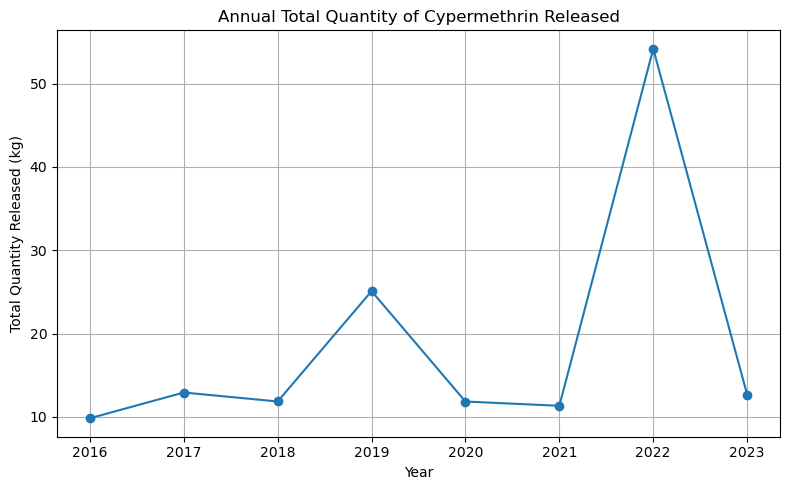

In [15]:
import matplotlib.pyplot as plt
yearly_totals = cyper.groupby('year')['quantity_released'].sum()
plt.figure(figsize=(8, 5))
plt.plot(yearly_totals.index, yearly_totals.values, marker='o')
plt.title('Annual Total Quantity of Cypermethrin Released')
plt.xlabel('Year')
plt.ylabel('Total Quantity Released (kg)')
plt.grid(True)
plt.tight_layout()
plt.show()

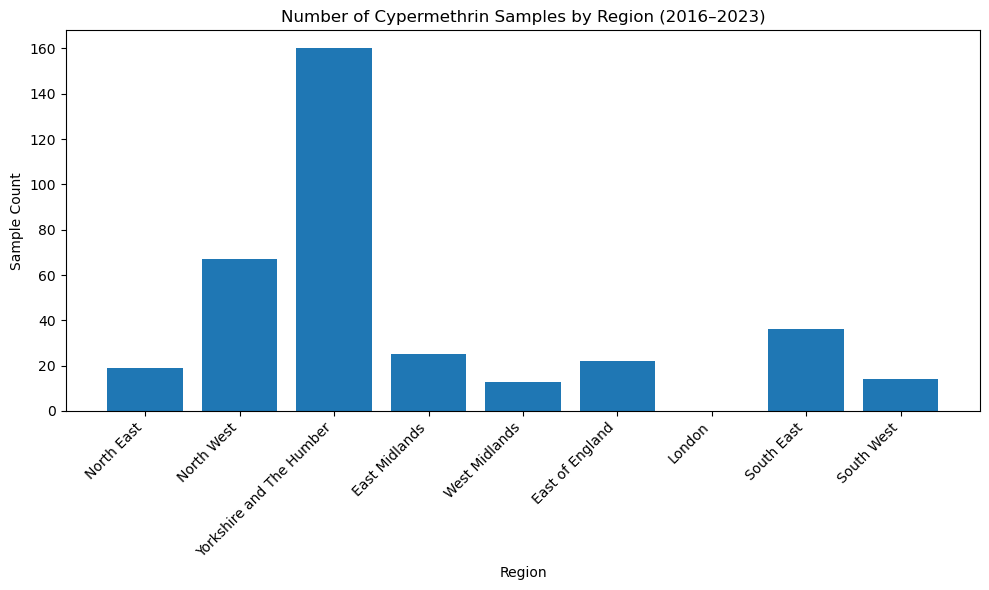

In [17]:
regions_ordered = ['North East','North West','Yorkshire and The Humber','East Midlands',
           'West Midlands','East of England','London','South East','South West']
counts_by_region = cyper['region'].value_counts().reindex(regions_ordered, fill_value=0)
plt.figure(figsize=(10, 6))
plt.bar(counts_by_region.index, counts_by_region.values)
plt.title('Number of Cypermethrin Samples by Region (2016–2023)')
plt.xlabel('Region')
plt.ylabel('Sample Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

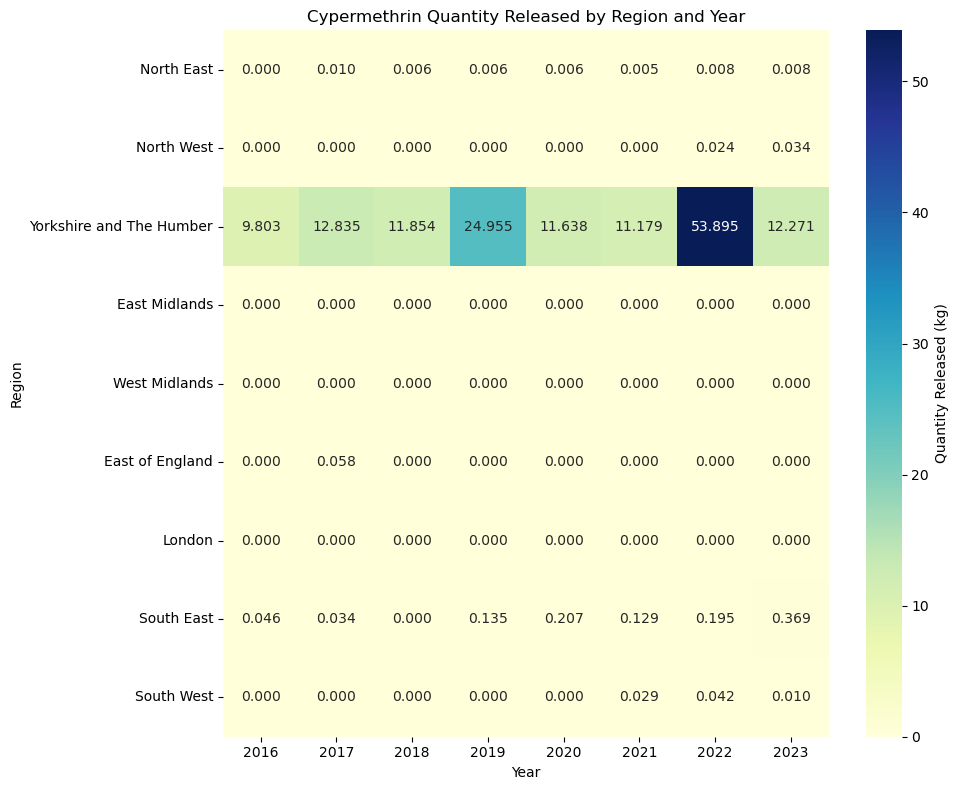

In [19]:
import seaborn as sns
heatmap_data = (
    cyper.groupby(['region','year'])['quantity_released']
         .sum()
         .unstack(fill_value=0)
         .reindex(index=regions_ordered, columns=sorted(cyper['year'].unique()), fill_value=0)
)
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlGnBu', cbar_kws={'label':'Quantity Released (kg)'})
plt.title('Cypermethrin Quantity Released by Region and Year')
plt.xlabel('Year')
plt.ylabel('Region')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show() 

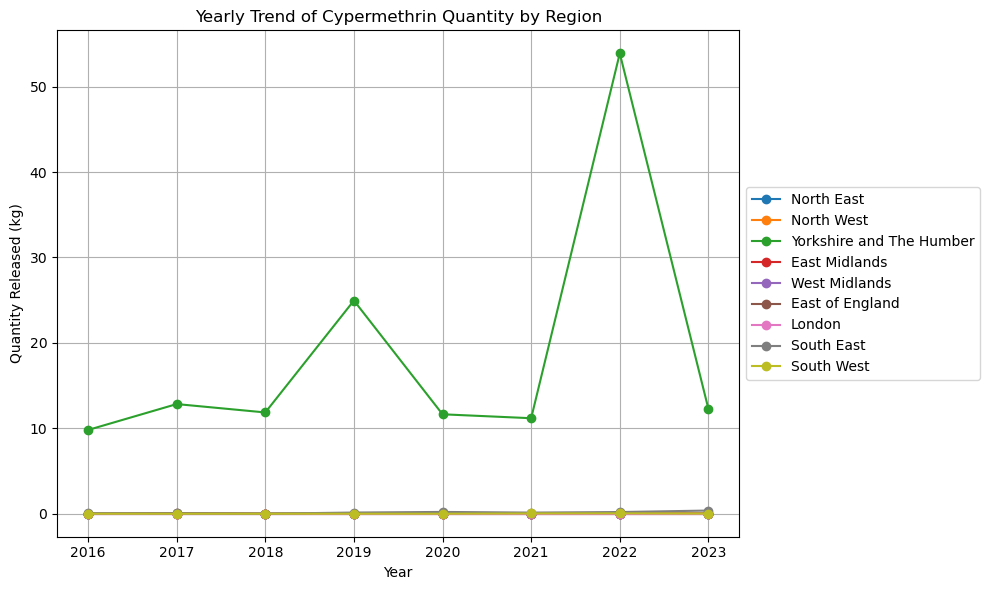

In [21]:
tmp = (
    cyper.groupby(['region','year'])['quantity_released']
         .sum()
         .unstack(fill_value=0)
         .reindex(index=regions_ordered, columns=sorted(cyper['year'].unique()), fill_value=0)
)

plt.figure(figsize=(10, 6))
for region in regions_ordered:
    series = tmp.loc[region]
    plt.plot(series.index, series.values, marker='o', label=region)

plt.title('Yearly Trend of Cypermethrin Quantity by Region')
plt.xlabel('Year')
plt.ylabel('Quantity Released (kg)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


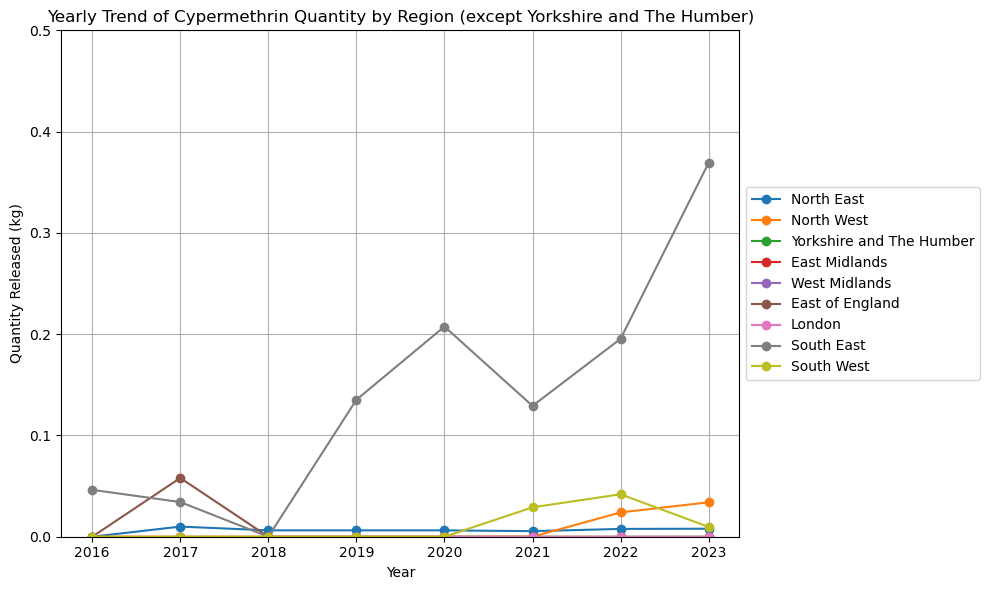

In [23]:
tmp = (
    cyper.groupby(['region','year'])['quantity_released']
         .sum()
         .unstack(fill_value=0)
         .reindex(index=regions_ordered, columns=sorted(cyper['year'].unique()), fill_value=0)
)

plt.figure(figsize=(10, 6))
for region in regions_ordered:
    series = tmp.loc[region]
    plt.plot(series.index, series.values, marker='o', label=region)

plt.title('Yearly Trend of Cypermethrin Quantity by Region (except Yorkshire and The Humber)')
plt.xlabel('Year')
plt.ylabel('Quantity Released (kg)')
plt.ylim(0, 0.5)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()